In [1]:
#Importação de bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import random
import os
import imageio.v2 as imageio
from PIL import Image
from tqdm import tqdm  # barra de progresso
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc as calc_auc, precision_recall_curve,  average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import MiniBatchKMeans
from skimage.transform import resize
from skimage.color import rgb2gray
import itertools
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,  GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model


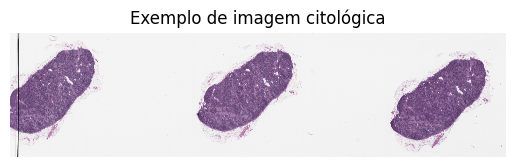

In [2]:
#carregar e visualizar as imagens 

# Caminho para a pasta onde estão os ficheiros .svs
image_folder = "/Volumes/TOSHIBA EXT/Trabalho final/SLN-Breast"
image_files = os.listdir(image_folder)

# Aumentar o limite de pixels para evitar o erro DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

#Carregar e mostrar uma imagem de exemplo
img_path = os.path.join(image_folder, image_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.title("Exemplo de imagem citológica")
plt.axis('off')
plt.show()

In [3]:
# Carregar dados suplementares
df = pd.read_csv("/Volumes/TOSHIBA EXT/Trabalho final/SLN-Breast/target.csv")

# Visualizar as primeiras linhas
print(df.head())

# Verificar distribuição das classes
print(df['target'].value_counts())

                     slide  target
0  HobI16-053768896760.svs       1
1  HobI16-072823783181.svs       1
2  HobI16-105105202254.svs       0
3  HobI16-303757967057.svs       0
4  HobI16-334188031493.svs       0
target
0    94
1    36
Name: count, dtype: int64


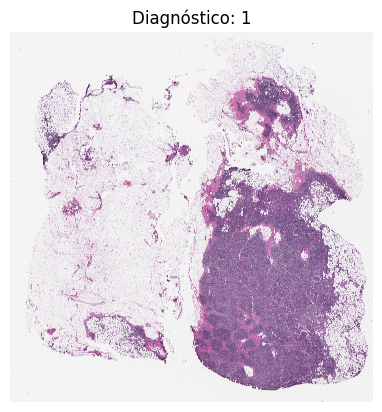

In [4]:
#Combinar as imagens com os dados do CSV
# Exemplo: carregar uma imagem com base no nome no CSV
sample = df.iloc[0]
img_path = os.path.join(image_folder, sample['slide'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Diagnóstico: {sample['target']}")
plt.axis('off')
plt.show()


[INFO] Extraindo patches com heurística e aumento de dados...
[INFO] Classe 0
[AVISO] Acabaram imagens antes de atingir 800 patches para classe 0
[INFO] Classe 1
[AVISO] Acabaram imagens antes de atingir 800 patches para classe 1
[INFO] Distribuição final de patches por classe:
Classe 0: 746 patches
Classe 1: 758 patches


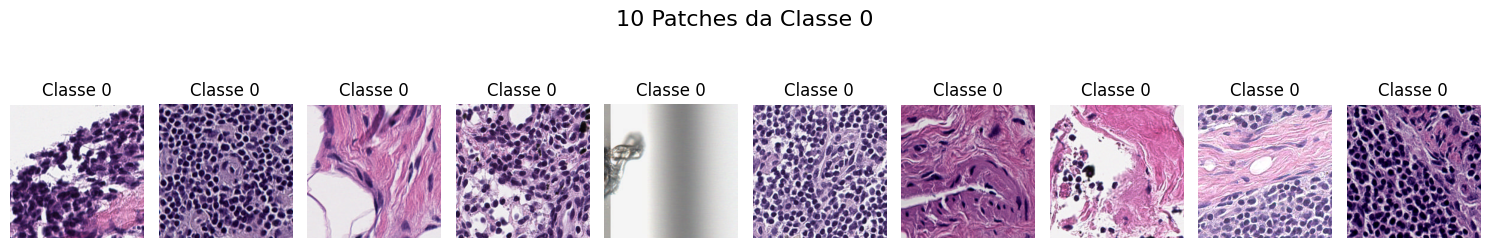

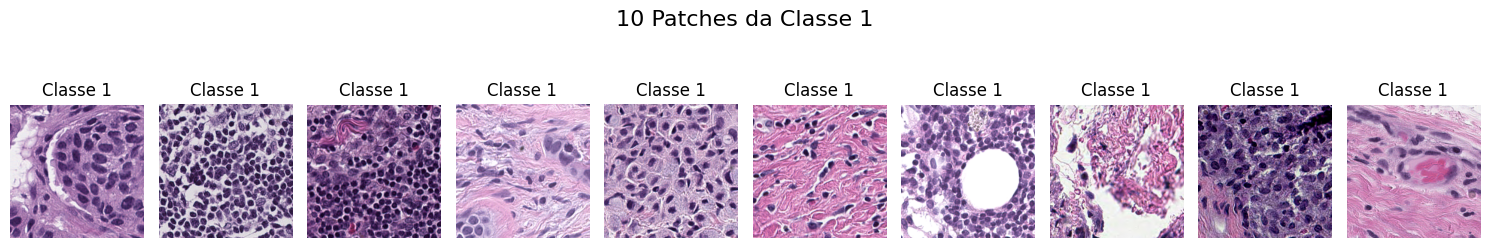

Total patches: 1504 | Shape: (1504, 224, 224, 3) | Class distribution: [746 758]
Total slides únicos: 130
[INFO] Extraindo features com EfficientNetB0...
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step
[INFO] Features extraídas com shape: (1504, 1280)

--- Fold 1/5 ---
[INFO] Treino: Counter({np.int64(1): 606, np.int64(0): 594}), Validação: Counter({np.int64(0): 152, np.int64(1): 152})
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 - 4s - 47ms/step - accuracy: 0.5967 - auc: 0.6496 - loss: 0.8096 - val_accuracy: 0.5691 - val_auc: 0.6955 - val_loss: 0.6539 - learning_rate: 1.0000e-04
Epoch 2/20
75/75 - 1s - 12ms/step - accuracy: 0.6925 - auc: 0.7623 - loss: 0.6355 - val_accuracy: 0.6053 - val_auc: 0.6959 - val_loss: 0.6470 - learning_rate: 1.0000e-04
Epoch 3/20
75/75 - 1s - 10ms/step - accuracy: 0.7250 - auc: 0.8057 - loss: 0.5633 - val_accuracy: 0.6382 - val_auc: 0.7057 - val_loss: 0.6318 - learning_rate: 1.0000e-04
Epoch 4/20
75/75 - 1s - 10ms/step - accuracy: 0.7525 - auc: 0.8282 - loss: 0.5383 - val_accuracy: 0.5493 - val_auc: 0.6005 - val_loss: 0.7105 - learning_rate: 1.0000e-04
Epoch 5/20
75/75 - 1s - 11ms/step - accuracy: 0.7533 - auc: 0.8344 - loss: 0.5201 - val_accuracy: 0.6151 - val_auc: 0.7002 - val_loss: 0.6634 - learning_rate: 1.0000e-04
Epoch 6/20
75/75 - 1s - 10ms/step - accuracy: 0.7717 - auc: 0.8638 - loss: 0.4679 - val_accuracy: 0.5921 - val_auc: 0.6343 - val_loss: 0.7870 - learning_rate: 1.

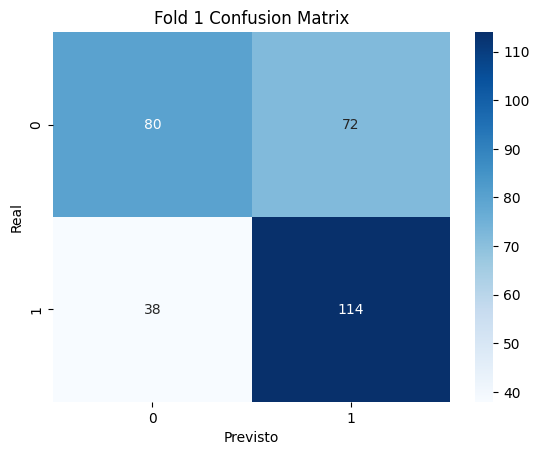


--- Fold 2/5 ---
[INFO] Treino: Counter({np.int64(1): 606, np.int64(0): 596}), Validação: Counter({np.int64(1): 152, np.int64(0): 150})
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 - 2s - 32ms/step - accuracy: 0.6256 - auc: 0.6719 - loss: 0.7504 - val_accuracy: 0.5530 - val_auc: 0.6093 - val_loss: 0.6811 - learning_rate: 1.0000e-04
Epoch 2/20
76/76 - 1s - 12ms/step - accuracy: 0.6839 - auc: 0.7591 - loss: 0.6315 - val_accuracy: 0.5662 - val_auc: 0.6421 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 3/20
76/76 - 1s - 14ms/step - accuracy: 0.7388 - auc: 0.8048 - loss: 0.5620 - val_accuracy: 0.6093 - val_auc: 0.6571 - val_loss: 0.6525 - learning_rate: 1.0000e-04
Epoch 4/20
76/76 - 1s - 11ms/step - accuracy: 0.7529 - auc: 0.8296 - loss: 0.5233 - val_accuracy: 0.5927 - val_auc: 0.6662 - val_loss: 0.6540 - learning_rate: 1.0000e-04
Epoch 5/20
76/76 - 1s - 10ms/step - accuracy: 0.7521 - auc: 0.8264 - loss: 0.5282 - val_accuracy: 0.5795 - val_auc: 0.6537 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 6/20
76/76 - 1s - 10ms/step - accuracy: 0.7637 - auc: 0.8476 - loss: 0.4925 - val_accuracy: 0.6093 - val_auc: 0.6864 - val_loss: 0.6965 - learning_rate: 1.

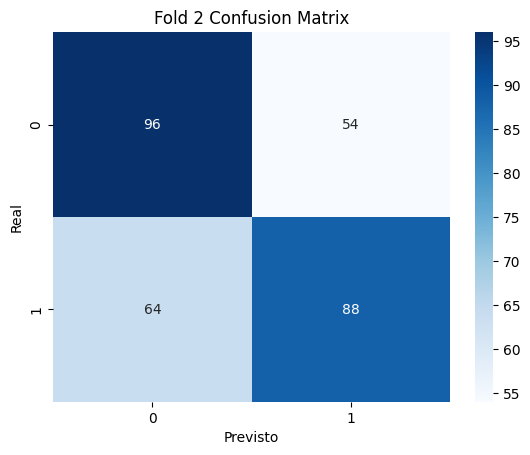


--- Fold 3/5 ---
[INFO] Treino: Counter({np.int64(0): 606, np.int64(1): 598}), Validação: Counter({np.int64(1): 160, np.int64(0): 140})


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
76/76 - 3s - 35ms/step - accuracy: 0.5947 - auc: 0.6523 - loss: 0.7677 - val_accuracy: 0.6667 - val_auc: 0.7449 - val_loss: 0.6256 - learning_rate: 1.0000e-04
Epoch 2/20
76/76 - 1s - 16ms/step - accuracy: 0.6711 - auc: 0.7469 - loss: 0.6389 - val_accuracy: 0.6633 - val_auc: 0.7271 - val_loss: 0.6065 - learning_rate: 1.0000e-04
Epoch 3/20
76/76 - 1s - 15ms/step - accuracy: 0.7193 - auc: 0.7865 - loss: 0.5954 - val_accuracy: 0.6500 - val_auc: 0.7063 - val_loss: 0.6191 - learning_rate: 1.0000e-04
Epoch 4/20
76/76 - 1s - 13ms/step - accuracy: 0.7168 - auc: 0.7959 - loss: 0.5698 - val_accuracy: 0.6467 - val_auc: 0.6940 - val_loss: 0.6587 - learning_rate: 1.0000e-04
Epoch 5/20
76/76 - 1s - 11ms/step - accuracy: 0.7658 - auc: 0.8494 - loss: 0.4838 - val_accuracy: 0.6767 - val_auc: 0.7219 - val_loss: 0.6346 - learning_rate: 2.0000e-05
Epoch 6/20
76/76 - 1s - 12ms/step - accuracy: 0.7542 - auc: 0.8462 - loss: 0.4911 - val_accuracy: 0.6700 - val_auc: 0.7202 - val_loss: 0.6501 - learni

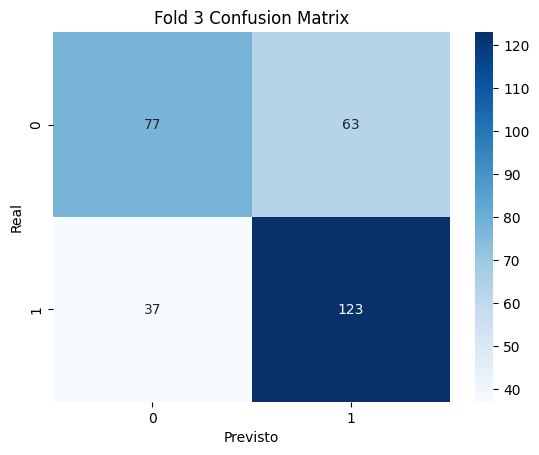


--- Fold 4/5 ---
[INFO] Treino: Counter({np.int64(1): 608, np.int64(0): 594}), Validação: Counter({np.int64(0): 152, np.int64(1): 150})
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 - 2s - 32ms/step - accuracy: 0.6090 - auc: 0.6385 - loss: 0.7961 - val_accuracy: 0.5199 - val_auc: 0.7878 - val_loss: 0.6544 - learning_rate: 1.0000e-04
Epoch 2/20
76/76 - 1s - 10ms/step - accuracy: 0.6772 - auc: 0.7493 - loss: 0.6370 - val_accuracy: 0.5464 - val_auc: 0.7555 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 3/20
76/76 - 1s - 9ms/step - accuracy: 0.7038 - auc: 0.7791 - loss: 0.5989 - val_accuracy: 0.5298 - val_auc: 0.7686 - val_loss: 0.7102 - learning_rate: 1.0000e-04
Epoch 4/20
76/76 - 1s - 9ms/step - accuracy: 0.7221 - auc: 0.7979 - loss: 0.5677 - val_accuracy: 0.6093 - val_auc: 0.7479 - val_loss: 0.6732 - learning_rate: 1.0000e-04
Epoch 5/20
76/76 - 1s - 10ms/step - accuracy: 0.7479 - auc: 0.8382 - loss: 0.5010 - val_accuracy: 0.6424 - val_auc: 0.7485 - val_loss: 0.6653 - learning_rate: 2.0000e-05
Epoch 6/20
76/76 - 1s - 9ms/step - accuracy: 0.7354 - auc: 0.8265 - loss: 0.5165 - val_accuracy: 0.6490 - val_auc: 0.7590 - val_loss: 0.6457 - learning_rate: 2.000

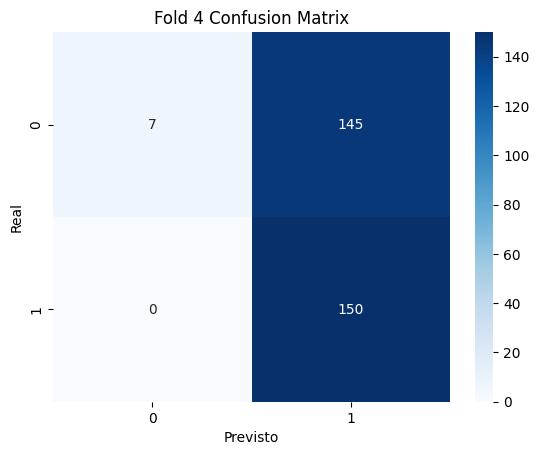


--- Fold 5/5 ---
[INFO] Treino: Counter({np.int64(1): 614, np.int64(0): 594}), Validação: Counter({np.int64(0): 152, np.int64(1): 144})
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 - 2s - 30ms/step - accuracy: 0.6200 - auc: 0.6516 - loss: 0.8004 - val_accuracy: 0.6047 - val_auc: 0.7024 - val_loss: 0.6469 - learning_rate: 1.0000e-04
Epoch 2/20
76/76 - 1s - 8ms/step - accuracy: 0.6598 - auc: 0.7312 - loss: 0.6753 - val_accuracy: 0.6689 - val_auc: 0.7529 - val_loss: 0.6127 - learning_rate: 1.0000e-04
Epoch 3/20
76/76 - 1s - 10ms/step - accuracy: 0.7227 - auc: 0.8030 - loss: 0.5605 - val_accuracy: 0.6318 - val_auc: 0.7007 - val_loss: 0.6146 - learning_rate: 1.0000e-04
Epoch 4/20
76/76 - 1s - 10ms/step - accuracy: 0.7227 - auc: 0.8019 - loss: 0.5815 - val_accuracy: 0.6858 - val_auc: 0.7588 - val_loss: 0.5763 - learning_rate: 1.0000e-04
Epoch 5/20
76/76 - 1s - 9ms/step - accuracy: 0.7583 - auc: 0.8266 - loss: 0.5286 - val_accuracy: 0.6892 - val_auc: 0.7749 - val_loss: 0.5617 - learning_rate: 1.0000e-04
Epoch 6/20
76/76 - 1s - 9ms/step - accuracy: 0.7682 - auc: 0.8540 - loss: 0.4908 - val_accuracy: 0.6892 - val_auc: 0.7557 - val_loss: 0.5884 - learning_rate: 1.000

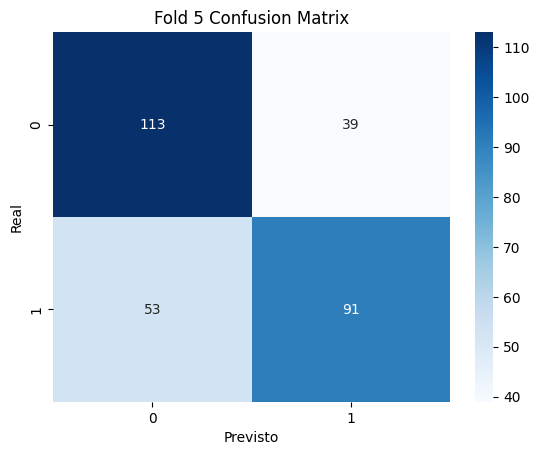


=== Resultados da Validação Cruzada ===
AUC por fold: ['0.7054', '0.6870', '0.7459', '0.7887', '0.7744']
AUC média: 0.7403 ± 0.0390


In [23]:


# --- Parâmetros ---
patch_size = 224
n_patches_por_classe = 800  # aumentar número para mais dados
min_tissue_ratio = 0.6
min_informacao_threshold = 0.20
max_informacao_threshold = 0.80
max_per_slide = 150
batch_size = 16
epochs_initial = 10
epochs_finetune = 10
k_folds = 5

# --- Função heurística para patches metastáticos ---
def patch_tem_metastase_heuristica(patch_array, std_thresh=0.08, mean_range=(0.25, 0.75)):
    std = patch_array.std()
    mean = patch_array.mean()
    return std > std_thresh and mean_range[0] < mean < mean_range[1]

# --- Função de data augmentation simples ---
def augment_patch(patch_array):
    patch_tf = tf.convert_to_tensor(patch_array, dtype=tf.float32)
    patch_tf = tf.image.random_flip_left_right(patch_tf)
    patch_tf = tf.image.random_flip_up_down(patch_tf)
    patch_tf = tf.image.random_brightness(patch_tf, max_delta=0.1)
    patch_tf = tf.image.random_contrast(patch_tf, lower=0.9, upper=1.1)
    patch_aug = patch_tf.numpy()
    patch_aug = np.clip(patch_aug, 0, 1)  # garantir intervalo [0,1]
    return patch_aug

# --- Extrair patches ---
data = []
counts_per_class = defaultdict(int)
df_grouped = df.groupby('target')

print("[INFO] Extraindo patches com heurística e aumento de dados...")

for classe, grupo in df_grouped:
    print(f"[INFO] Classe {classe}")
    imagens_classe = grupo['slide'].tolist()
    random.shuffle(imagens_classe)

    idx_imagem = 0
    while counts_per_class[classe] < n_patches_por_classe:
        if idx_imagem >= len(imagens_classe):
            print(f"[AVISO] Acabaram imagens antes de atingir {n_patches_por_classe} patches para classe {classe}")
            break

        file_path = os.path.join(image_folder, imagens_classe[idx_imagem])
        idx_imagem += 1

        try:
            slide = openslide.OpenSlide(file_path)
            slide_w, slide_h = slide.dimensions
            patches_collected = 0
            max_attempts = 200  # aumentar tentativas para garantir patches bons
            attempts = 0

            while patches_collected < (n_patches_por_classe // len(imagens_classe)) and attempts < max_attempts:
                x = random.randint(0, slide_w - patch_size)
                y = random.randint(0, slide_h - patch_size)
                patch = slide.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
                patch_array = np.array(patch) / 255.0  # normalizar para [0,1]

                tissue_ratio = (patch_array.mean(axis=2) < 0.9).mean()
                info_media = patch_array.mean()

                if tissue_ratio >= min_tissue_ratio and min_informacao_threshold <= info_media <= max_informacao_threshold:
                    if classe == 1:
                        if patch_tem_metastase_heuristica(patch_array):
                            # Guardar patch original
                            data.append((patch_array, classe, os.path.basename(file_path)))
                            counts_per_class[classe] += 1
                            patches_collected += 1
                            # Gerar patch augmentado para aumentar diversidade
                            patch_aug = augment_patch(patch_array)
                            data.append((patch_aug, classe, os.path.basename(file_path)))
                            counts_per_class[classe] += 1
                            patches_collected += 1
                    else:
                        data.append((patch_array, classe, os.path.basename(file_path)))
                        counts_per_class[classe] += 1
                        patches_collected += 1
                        # Também aumentar dados da classe negativa com augmentation
                        patch_aug = augment_patch(patch_array)
                        data.append((patch_aug, classe, os.path.basename(file_path)))
                        counts_per_class[classe] += 1
                        patches_collected += 1

                attempts += 1
        except Exception as e:
            print(f"[ERRO] {file_path}: {e}")

print("[INFO] Distribuição final de patches por classe:")
for classe, count in counts_per_class.items():
    print(f"Classe {classe}: {count} patches")

# --- Visualização ---
def mostrar_patches_por_classe(data, n=5):
    classes = set(label for (_, label, _) in data)
    for classe in classes:
        patches_classe = [img for img, label, _ in data if label == classe]
        num_to_show = min(n, len(patches_classe))
        amostras = random.sample(patches_classe, num_to_show)
        plt.figure(figsize=(15, 3))
        for i, patch in enumerate(amostras):
            plt.subplot(1, num_to_show, i + 1)
            plt.imshow(patch)
            plt.title(f"Classe {classe}")
            plt.axis('off')
        plt.suptitle(f"{num_to_show} Patches da Classe {classe}", fontsize=16)
        plt.tight_layout()
        plt.show()

mostrar_patches_por_classe(data, n=10)

# --- Preparar dados ---
X = np.array([img for img, _, _ in data])
y = np.array([label for _, label, _ in data])
groups = np.array([gid for _, _, gid in data])

print(f"Total patches: {len(X)} | Shape: {X.shape} | Class distribution: {np.bincount(y)}")
print(f"Total slides únicos: {len(np.unique(groups))}")

# --- Extração de features EfficientNetB0 ---
print("[INFO] Extraindo features com EfficientNetB0...")

base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
base.trainable = False
feature_extractor = models.Model(inputs=base.input,
                                 outputs=layers.GlobalAveragePooling2D()(base.output))

# Corrigir preprocessing para EfficientNet: inputs uint8 [0,255]
X_uint8 = (X * 255).astype(np.uint8)
X_preproc = preprocess_input(X_uint8)

X_features = feature_extractor.predict(X_preproc, batch_size=batch_size, verbose=1)
print(f"[INFO] Features extraídas com shape: {X_features.shape}")

# --- Modelo MLP com validação cruzada GroupKFold ---
gkf = GroupKFold(n_splits=k_folds)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_features, y, groups=groups), 1):
    print(f"\n--- Fold {fold}/{k_folds} ---")

    slide_ids_train = groups[train_idx]
    selected = []
    for slide in np.unique(slide_ids_train):
        idxs = train_idx[slide_ids_train == slide]
        n = min(len(idxs), max_per_slide)
        selected.extend(np.random.choice(idxs, n, replace=False))
    selected = np.array(selected)

    X_train_cv = X_features[selected]
    y_train_cv = y[selected]
    X_val_cv = X_features[val_idx]
    y_val_cv = y[val_idx]

    print(f"[INFO] Treino: {Counter(y_train_cv)}, Validação: {Counter(y_val_cv)}")

    cw_vals = compute_class_weight('balanced', classes=np.unique(y_train_cv), y=y_train_cv)
    class_weights = dict(enumerate(cw_vals))

    input_dim = X_features.shape[1]
    model = models.Sequential([
        layers.Dense(1024, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    cb_list = [
        callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=3, mode='max', min_lr=1e-7)
    ]

    history = model.fit(
        X_train_cv, y_train_cv,
        validation_data=(X_val_cv, y_val_cv),
        epochs=epochs_initial + epochs_finetune,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=cb_list,
        verbose=2
    )

    y_pred_proba = model.predict(X_val_cv).ravel()
    auc = roc_auc_score(y_val_cv, y_pred_proba)
    auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")

    y_pred = (y_pred_proba > 0.5).astype(int)
    cm = confusion_matrix(y_val_cv, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Fold {fold} Confusion Matrix")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

print("\n=== Resultados da Validação Cruzada ===")
print(f"AUC por fold: {[f'{s:.4f}' for s in auc_scores]}")
print(f"AUC média: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
